# CNN Project - Image Classification using Deep CNN in Keras.


This is multi-class classification

<h1>Problem Statement<h1/>

-  Differentiate a weed from a crop seedling


<h1>1. Import the libraries, load dataset, print shape of data, visualize the images in dataset.<h1/>

In [1]:
# Import necessary modules.

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from IPython.display import Image  
import pandas as pd
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, Activation
from matplotlib.pyplot import imshow, show
from tensorflow.keras import datasets, models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab.patches import cv2_imshow
print(tf.__version__)

2.4.1


In [2]:
#To ensure reproducible results in Keras, we have to execute follwing commands
import random
np.random.seed(123)
#python_random.seed(123)
tf.random.set_seed(1234)
random.seed(0)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Set the batch size, number of epochs.
#batch_size = 32
batch_size = None
num_classes = 12
epochs = 100


Load images and labels

In [5]:
X = np.load('/content/drive/My Drive/Colab Notebooks/images.npy')

y = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Labels.csv')

In [6]:
y.value_counts()

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
dtype: int64

Data seems fairly distributed in 12 classes

In [7]:
# Check the data
print(np.isnan(np.sum(X)))

False


There are no null values. Null values can significantly impact CNN

In [8]:
print(X.shape)
print(y.shape)

(4750, 128, 128, 3)
(4750, 1)


Images are color images (3 channels)

In [9]:
y = y.values   #converting to ndarray

Text(0.5, 1.0, "['Small-flowered Cranesbill']")

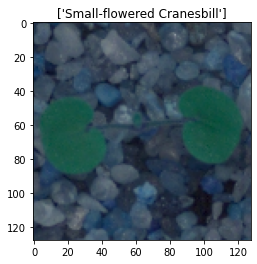

In [10]:
#Visualising an image
i=0
img = X[i]
#img = img.reshape((128,128))
plt.imshow(img)
plt.title(y[i])

<h1>2. Data Pre-processing.<h1/>

In [11]:
# Normalize the data
X = X.astype('float32') / 255.0 #Whole X normalized



In [12]:
flattened_x = X[0].flatten() #for checking the distribution before blurring

(array([7.4500e+02, 5.1000e+03, 7.1200e+03, 9.6050e+03, 1.3079e+04,
        8.9680e+03, 3.8040e+03, 6.5900e+02, 7.0000e+01, 2.0000e+00]),
 array([0.00784314, 0.07254902, 0.13725491, 0.20196079, 0.26666668,
        0.33137256, 0.39607844, 0.46078432, 0.5254902 , 0.5901961 ,
        0.654902  ], dtype=float32),
 <a list of 10 Patch objects>)

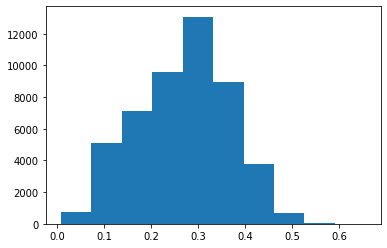

In [13]:
plt.hist(flattened_x)

In [14]:
print(len(X)) # Check the number of rows in the dataset.
print(X.shape) # 

4750
(4750, 128, 128, 3)


In [15]:
#Apply Gaussian blurring
# Now we create an empty numpy array, which will be used to store the new values after applying Gaussian Blurring filter to the original image.
new_x = np.empty((4750, 128, 128, 3)) 

In [16]:
# We can see that each digit is made of 784 pixels.
X[0].shape 

(128, 128, 3)

In [17]:
# Here we see that the length of new dataset after application of Gaussian Blurring filter is same as previous one.
# i.e. Total number of images is same.
len(new_x)

4750

In [18]:
# In the following step, we iterate through each row, and convert the 1-D array of 784 pixels to an 
# array of 28x28 pixels 2-D array. 
for idx, line in enumerate(X):
  new_x[idx] = line

In [19]:
# Now we apply the gaussian blur to each 28x28 pixels array (image) to reduce the noise in the image
for idx, line in enumerate(new_x):
  new_x[idx] = cv2.GaussianBlur(line, (5, 5), 0)

Text(0.5, 1.0, "['Small-flowered Cranesbill']")

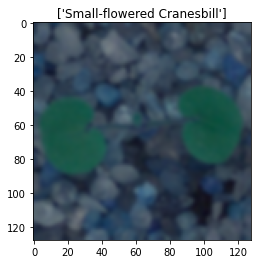

In [20]:
# Plot the de-noised image generated by applying Gaussian blur.
i = 0
plt.imshow(new_x[i])
plt.title(y[i])

In [21]:
# Now we create another empty numpy array of 10008 rows and 784 columns shape, to store the pixel values, which are obtained by applying the Gaussian Blur.
# The new array is necessary as we have to feed the data in the model in this original format.
another_x = np.empty((4750, 49152))

In [22]:
for idx, line in enumerate(new_x):
  another_x[idx] = line.flatten()

(array([  948.,  4156.,  5687.,  7663., 10697., 10589.,  6031.,  2726.,
          592.,    63.]),
 array([0.03216912, 0.08467525, 0.13718138, 0.18968751, 0.24219364,
        0.29469977, 0.3472059 , 0.39971203, 0.45221816, 0.50472429,
        0.55723042]),
 <a list of 10 Patch objects>)

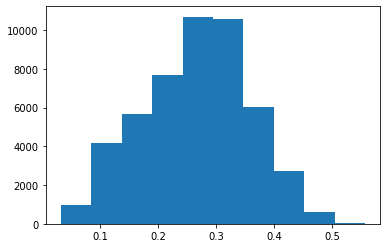

In [23]:
plt.hist(another_x[0]) #checking distribution of Gaussian blurred line

Not much visible difference in the pixel distribution of this image but visually we can see more blurred image. I cannot be 100% sure whether we need blurring in this case but from learning point of view I shall go ahead with the blurred dataset for rest of processing

<h1>3. Make Data compatible<h1/>

In [24]:
label_dict =  {'Loose Silky-bent':0, 'Common Chickweed':1, 'Scentless Mayweed':2, 'Small-flowered Cranesbill':3, 'Fat Hen':4, 'Charlock':5, 'Sugar beet':6, 'Cleavers':7, 'Black-grass':8, 'Shepherds Purse':9, 'Maize':10, 'Common wheat':11}

In [25]:
def reverse_dict(dictionary, lookup_val): #for printing original label from number
    for key,value in dictionary.items():
        if value == lookup_val:
            return key

In [26]:
#convert labels to integers in y so that they could be converted to onehot later
for i in range(0, len(y)):
  idxvalue = y[i][0]
  newvalue = label_dict[idxvalue]
  y[i][0] = newvalue

In [27]:
np.unique(y, return_counts=True) #for cheking integer encoded labels match original distribution

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], dtype=object),
 array([654, 611, 516, 496, 475, 390, 385, 287, 263, 231, 221, 221]))

In [28]:
print(y[0]) #just printing one value for y, y_train[0] would be printed after the train/test split and after onehot encoding of y

[3]


In [29]:
# The data, split between train and test sets: (note another_x represents gaussian blurred X) and then
#further split the test in test and validation
X_train, X_test, y_train, y_test = train_test_split(another_x, y, test_size=0.3, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(new_x, y, test_size=0.3, random_state=0)


In [30]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [31]:
# Print the shape of dataset.
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(X_val.shape[0], 'val samples')
print(type(X_train))

x_train shape: (3325, 49152)
3325 train samples
712 test samples
713 val samples
<class 'numpy.ndarray'>


In [32]:
y_train.shape

(3325, 1)

In [33]:
type(y_train)

numpy.ndarray

In [34]:
#print label for y_train[0]
print("label id ", y_train[0], "label ", reverse_dict(label_dict, y_train[0]) )

label id  [7] label  Cleavers


In [35]:
# Convert categorical target field to one hot encoded fields
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_oh= tf.keras.utils.to_categorical(y_val, num_classes)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes)

In [36]:
#print the labels for y_train[0], y_val[0] and y_test[0]
print (y_train_oh[0])
print(y_val_oh[1])
print(y_test_oh[1])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Label 
 Label Id: 3 
 Name: Small-flowered Cranesbill


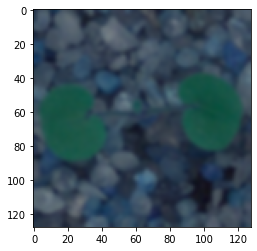

In [37]:
#create an image and check sobel filtering for edges
i = 0
image = new_x[i]
label = y[i][0]
#print(' Label \n Label Id: {} \n Name: {}'.format(label, label_dict[label]))
print(f'Label \n Label Id: {label} \n Name: {reverse_dict(label_dict, label)}')
plt.imshow(image);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


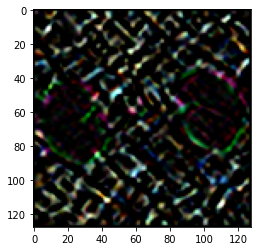

In [38]:
#Applying Sobel to check how edges look
sobel = cv2.Sobel(image, cv2.CV_64F, 1, 1, ksize=5)
plt.imshow(sobel)

- As the image quality is not good, the edges are not so good. But still we can visualize that there are edges.

In [39]:
y_train[0]

array([7], dtype=object)

In [40]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(3325, 1)
(713, 1)
(712, 1)


In [41]:
y_train[0]

array([7], dtype=object)

Check shape of the data and reshape if necessary.
Our current X is flattened after Gaussian blurring because we wanted to check distribution. This will not be accepted by CNN as CNN expects tensor with the channles intact. So we must reshape the X before we feed it to the model

In [42]:
X_train = X_train.reshape(X_train.shape[0], 128, 128, 3)
X_val = X_val.reshape(X_val.shape[0], 128, 128, 3)

X_test = X_test.reshape(X_test.shape[0], 128, 128, 3)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(3325, 128, 128, 3)
(712, 128, 128, 3)
(713, 128, 128, 3)


In [43]:
X_train[9, :, :, :].shape #checking shape of one value

(128, 128, 3)

In [44]:
#Also ensure our normalization is intact by checking max values (should be <=1)
print(X_train.max())
print(X_val.max())
print(X_test.max())


0.999816176481545
0.9967064952943474
0.9978094364050776


Now we are ready for the model

<h1>4. Building CNN<h1/>
CNN is being built with follwoing layers. 2 different models will be tried and will print confusion matrix and predictions for the one with higher test accuracy scores.

- Convolutional input layer
- Batch Normalization Layer.
- Convolutional layer
- Batch Normalization layer.
- Max Pool layer 
- Dropout layer 
- Flattened layer or Global Max pooling
- Fully connected layer with 256 units and a rectifier activation function.
- Fully connected output layer with 12 units and a softmax activation function.

The main difference between the 2 models is that one uses global max pooling whereas other uses Flatten. Both can be used to transform the input to make it suitable for dense layer. I shall pick up the model which gives me better accuracy.

In [45]:
# Set the CNN model

batch_size = None

model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), padding='same', activation="relu", input_shape=X_train.shape[1:]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (5, 5), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

#model.add(layers.GlobalMaxPooling2D())

model.add(Flatten())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

In [46]:
# initiate Adam optimizer
opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [47]:
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [48]:
# Network structure is summarized which confirms our design was implemented correctly.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

In [49]:
X_train = X_train.astype('float32') # Conversion to float type from integer type.
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')
print(X_train.max())
print(X_val.max())
print(X_test.max())
#x_train /= 255.0 # Division by 255
#x_test /= 255.0

0.9998162
0.9967065
0.9978094


In [50]:
#Adding Early stopping callback to the fit function is going to stop the training,
#if the val_loss is not going to change even '0.001' for more than 10 continous epochs
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training

model_checkpoint =  ModelCheckpoint('cifar_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)

<h1>5. Fit and evaluate model and print confusion matrix.<h1/>


Epoch 1/100
104/104 [==============================] - 6s 35ms/step - loss: 4.0891 - accuracy: 0.2379 - val_loss: 10.9392 - val_accuracy: 0.0421

Epoch 00001: val_loss improved from inf to 10.93915, saving model to cifar_cnn_checkpoint_01_loss10.9392.h5
Epoch 2/100
104/104 [==============================] - 3s 28ms/step - loss: 1.5216 - accuracy: 0.4747 - val_loss: 8.0160 - val_accuracy: 0.0407

Epoch 00002: val_loss improved from 10.93915 to 8.01604, saving model to cifar_cnn_checkpoint_02_loss8.0160.h5
Epoch 3/100
104/104 [==============================] - 3s 29ms/step - loss: 1.1293 - accuracy: 0.6284 - val_loss: 7.9405 - val_accuracy: 0.0407

Epoch 00003: val_loss improved from 8.01604 to 7.94053, saving model to cifar_cnn_checkpoint_03_loss7.9405.h5
Epoch 4/100
104/104 [==============================] - 3s 29ms/step - loss: 0.9490 - accuracy: 0.6761 - val_loss: 4.8927 - val_accuracy: 0.1697

Epoch 00004: val_loss improved from 7.94053 to 4.89265, saving model to cifar_cnn_checkpoi

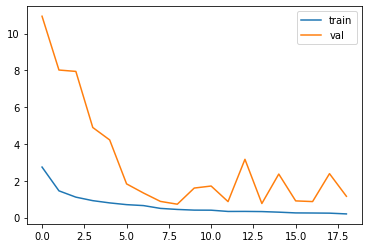

In [51]:
history = model.fit(X_train,
                    y_train_oh,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val_oh),
                    shuffle=True,
                    verbose=1,
                    callbacks=[early_stopping,model_checkpoint])

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

<h2>Model Score:<h2/>

- Once the model is fit, we evaluate it on the test dataset and print out the classification accuracy and confusion matrix. We can see the validation accuracy has reached 84%. Validation loss is oscillating but finally converging with training loss. Anyway the fitness of the model will be determined by test accuracy.

In [52]:
# Score trained model.
scores = model.evaluate(X_test, y_test_oh, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 0s 11ms/step - loss: 1.2080 - accuracy: 0.7472
Test loss: 1.2080460786819458
Test accuracy: 0.7471910119056702


Test accuracy is 74.72%, which seems good

<h2>Now try with second model:<h2/>



In [53]:
%%time
tf.keras.backend.clear_session()
tf.random.set_seed(1)

model2 = models.Sequential()
model2.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(layers.GlobalMaxPooling2D())
#model2.add(Flatten())
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dropout(0.25))
model2.add(Dense(num_classes))
model2.add(Activation('softmax'))

# compile model
model2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


# adding constraints
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training

model_checkpoint =  ModelCheckpoint('cifar_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto')

print(model2.summary())

# Fitting the model
history = model2.fit(X_train,
                    y_train_oh,
                    #batch_size=batch_size,
                    epochs= epochs,
                    validation_data=(X_val, y_val_oh),
                    shuffle=True,
                    verbose=1,
                    callbacks=[early_stopping,model_checkpoint])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        1

In [54]:
# Score trained model.
scores = model2.evaluate(X_test, y_test_oh, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 0s 11ms/step - loss: 0.4487 - accuracy: 0.8244
Test loss: 0.448676198720932
Test accuracy: 0.824438214302063


## The accuracy of model2 is even better (82.44%) so we shall use this model for further evaluation and prediction

In [55]:
from sklearn.metrics import classification_report, confusion_matrix
#from tf.math import confusion_matrix

In [69]:
y_pred = model2.predict(X_test) #Note predict_classes has been deprecated so have to use predict and then argmax

In [57]:
y_pred[0]

array([5.38018270e-08, 9.98510063e-01, 3.06351831e-05, 1.57673057e-07,
       2.86683116e-05, 3.38588435e-10, 1.02365026e-04, 5.53780688e-10,
       7.18873228e-09, 1.04991204e-06, 1.32698787e-03, 5.18743759e-09],
      dtype=float32)

In [71]:
y_pred.shape

(712, 12)

In [72]:
y_test[0]

array([1], dtype=object)

In [73]:
y_test.shape

(712, 1)

In [74]:
y_test_oh[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [75]:
y_pred_cm = y_pred.argmax(axis=1) # to convert the y_pred probabilities generated by softmax, to numbers
y_test_cm = y_test_oh.argmax(axis=1) #idealy we can use y_test here but this command makes dimensions of the test and predict matrix same for CM purpose

In [76]:
y_pred_cm.shape

(712,)

In [77]:
print(type(y_test))
print(type(y_pred_cm))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [78]:
y_pred_cm[0] #a sample value

1

In [79]:
print("=== Confusion Matrix ===")
cm =confusion_matrix(y_test_oh.argmax(axis=1), y_pred_cm)

#cm = confusion_matrix(y_test, y_pred_cm)
print(cm)

=== Confusion Matrix ===
[[78  0  2  0  0  0  0  0 19  0  0  2]
 [ 0 84  3  0  0  0  0  0  0  0  1  0]
 [ 0  0 70  0  0  0  2  0  0  2  0  0]
 [ 0  2  0 65  2  0  0  2  0  1  0  0]
 [ 0  0  0  0 71  0  0  1  0  1  0  1]
 [ 0  0  5  0  0 33  5  9  0  3  0  0]
 [ 0  0  3  0  0  1 42  0  0  0  0  1]
 [ 0  1  0  0  1  0  1 44  0  1  0  1]
 [12  0  0  0  1  0  0  0 24  0  0  4]
 [ 0 10 12  0  2  1  2  0  0 21  0  0]
 [ 0  1  0  0  1  0  0  0  0  0 27  1]
 [ 0  0  0  0  3  0  1  0  0  0  1 28]]


=== Confusion Matrix ===


{'Black-grass': 8,
 'Charlock': 5,
 'Cleavers': 7,
 'Common Chickweed': 1,
 'Common wheat': 11,
 'Fat Hen': 4,
 'Loose Silky-bent': 0,
 'Maize': 10,
 'Scentless Mayweed': 2,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 3,
 'Sugar beet': 6}

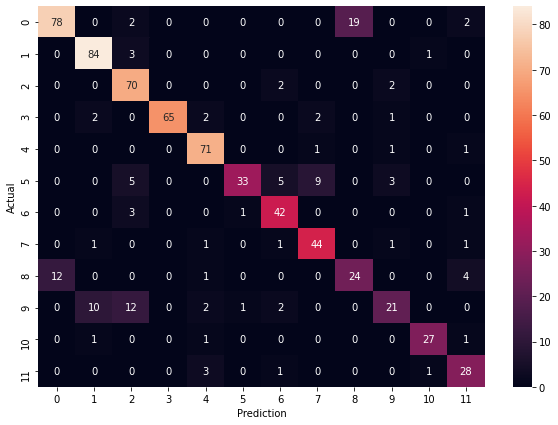

In [80]:
#confusion matrix in better form
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

print("=== Confusion Matrix ===")
cm = pd.crosstab(y_test_cm, y_pred_cm, rownames = ['Actual'], colnames = ['Prediction'])
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt='d');

label_dict

<h3>The above score shows that the accuracy is good.
If we use more epochs and tune the hyper-parameters more then we can get some more accuracy score. <h3/>

<h1>6. Visualize predictions for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59].<h1/>
<h2>We have already used model.predict on whole X_test so I shall print predicted label and actual label from y_pred and y_test respectively and print image from X_test where the image label corresponds to predicted value. Note that these may be different as accuracy is not 100%</h2>

this is i 2
Predicted label 8 Black-grass
Actual label [0] Loose Silky-bent
this is k 21


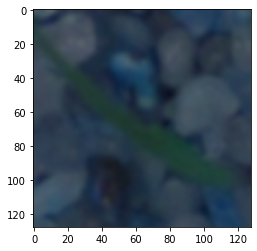

this is i 3
Predicted label 1 Common Chickweed
Actual label [1] Common Chickweed
this is k 3


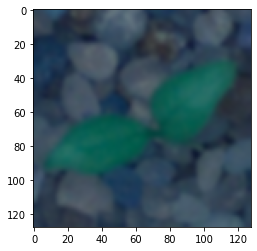

this is i 33
Predicted label 11 Common wheat
Actual label [11] Common wheat
this is k 33


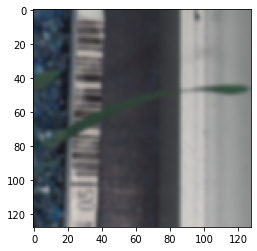

this is i 36
Predicted label 11 Common wheat
Actual label [11] Common wheat
this is k 36


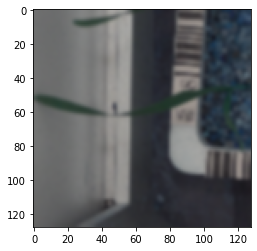

this is i 59
Predicted label 3 Small-flowered Cranesbill
Actual label [3] Small-flowered Cranesbill
this is k 59


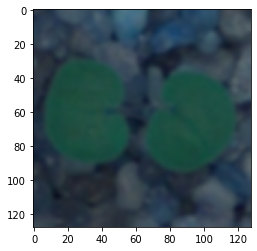

In [81]:
for i in [2,3,33,36,59]:
  print("this is i", i)
  print("Predicted label", y_pred_cm[i], reverse_dict(label_dict, y_pred_cm[i]))
  #print("Actual label", y_test_cm[i], reverse_dict(label_dict, y_test_cm[i]) )
  print("Actual label", y_test[i], reverse_dict(label_dict, y_test[i]) )
  #to print predicted image, pick up any X test where the image matches the predicted label, if the predicted label is same as
  #actual label then just use the current value i.e. X_test[i]
  k = 0
  if y_pred_cm[i].astype('int') == y_test[i].astype('int'):
    k = i
  else:
    for j in range(0, len(y_test)):
      if y_pred_cm[i].astype('int') == y_test[j].astype('int'):
        k = j
        break
        
  print("this is k", k) 
  plt.imshow(X_test[k])
  show()

<h1>4 out 5 predictions are correct, consistent with the accuracy</h1>